In [6]:
# %pip install -qU pypdf
# %pip install -qU langchain-unstructured
# %pip install -qU "unstructured[pdf]"
# %pip install -qU matplotlib PyMuPDF pillow

Note: you may need to restart the kernel to use updated packages.


## Extracting texts with PyPDFLoader

In [1]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "data/scholar_corpus/0KCrVeiC5zEJ.pdf"

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [35]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf', 'page': 0}

Distillation Contrastive Decoding: Improving LLMs Reasoning with
Contrastive Decoding and Distillation
Phuc Phan∗, Hieu Tran∗ and Long Phan
VietAI Research
Abstract
We propose a straightforward approach called
Distillation Contrastive Decoding (DCD) to en-
hance the reasoning capabilities of Large Lan-
guage Models (LLMs) during inference. In
contrast to previous approaches that relied on
smaller amateur models or analysis of hidden
state differences, DCD employs Contrastive
Chain-of-thought Prompting and advanced dis-
tillation techniques, including Dropout and
Quantization. This approach effectively ad-
dresses the limitations of Contrastive Decoding
(CD), which typically requires both an expert
and an amateur model, thus increasing compu-
tational resource demands. By integrating con-
trastive prompts with distillation, DCD obvi-
ates the need for an amateur model and reduces
memory usage. Our evaluations demonstrate
tha

## Extracting texts, images & tables with Unstructured API

In [4]:
import getpass
import os

if "UNSTRUCTURED_API_KEY" not in os.environ:
    os.environ["UNSTRUCTURED_API_KEY"] = getpass.getpass("Unstructured API Key:")

In [ ]:
from langchain_unstructured import UnstructuredLoader

file_path = "data/scholar_corpus/0KCrVeiC5zEJ.pdf"

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


In [7]:
print(len(docs))

282


In [22]:
from pprint import pprint
pprint(docs[0])

Document(metadata={'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf', 'coordinates': {'points': [[239.49673461914062, 215.12583923339844], [239.49673461914062, 304.54315185546875], [1428.896484375, 304.54315185546875], [1428.896484375, 215.12583923339844]], 'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'filename': '0KCrVeiC5zEJ.pdf', 'category': 'Title', 'element_id': '02adfadb9fba5f3f602d1e32ddc55b0b'}, page_content='Distillation Contrastive Decoding: Improving LLMs Reasoning with Contrastive Decoding and Distillation')


In [8]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)

Distillation Contrastive Decoding: Improving LLMs Reasoning with Contrastive Decoding and Distillation
Phuc Phan∗, Hieu Tran∗ and Long Phan VietAI Research
4 2 0 2 g u A 3 2 ] L C . s c [ 2 v 4 7 8 4 1 . 2 0 4 2 : v i X r a
Abstract
We propose a straightforward approach called Distillation Contrastive Decoding (DCD) to en- hance the reasoning capabilities of Large Lan- guage Models (LLMs) during inference. In contrast to previous approaches that relied on smaller amateur models or analysis of hidden state differences, DCD employs Contrastive Chain-of-thought Prompting and advanced dis- tillation techniques, including Dropout and Quantization. This approach effectively ad- dresses the limitations of Contrastive Decoding (CD), which typically requires both an expert and an amateur model, thus increasing compu- tational resource demands. By integrating con- trastive prompts with distillation, DCD obvi- ates the need for an amateur model and reduces memory usage. Our evaluations demonstrat

In [34]:
print(first_page_docs[0].id)
pprint(first_page_docs[0].metadata)
print(first_page_docs[0].type)

None
{'category': 'Title',
 'coordinates': {'layout_height': 2339,
                 'layout_width': 1654,
                 'points': [[239.49673461914062, 215.12583923339844],
                            [239.49673461914062, 304.54315185546875],
                            [1428.896484375, 304.54315185546875],
                            [1428.896484375, 215.12583923339844]],
                 'system': 'PixelSpace'},
 'element_id': '02adfadb9fba5f3f602d1e32ddc55b0b',
 'filename': '0KCrVeiC5zEJ.pdf',
 'filetype': 'application/pdf',
 'languages': ['eng'],
 'page_number': 1,
 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}
Document


In [30]:
for prop in vars(first_page_docs[0]):
    if not prop.startswith('__'):
        print(prop)
# first_page_docs[0].page_content

id
metadata
page_content
type


In [12]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

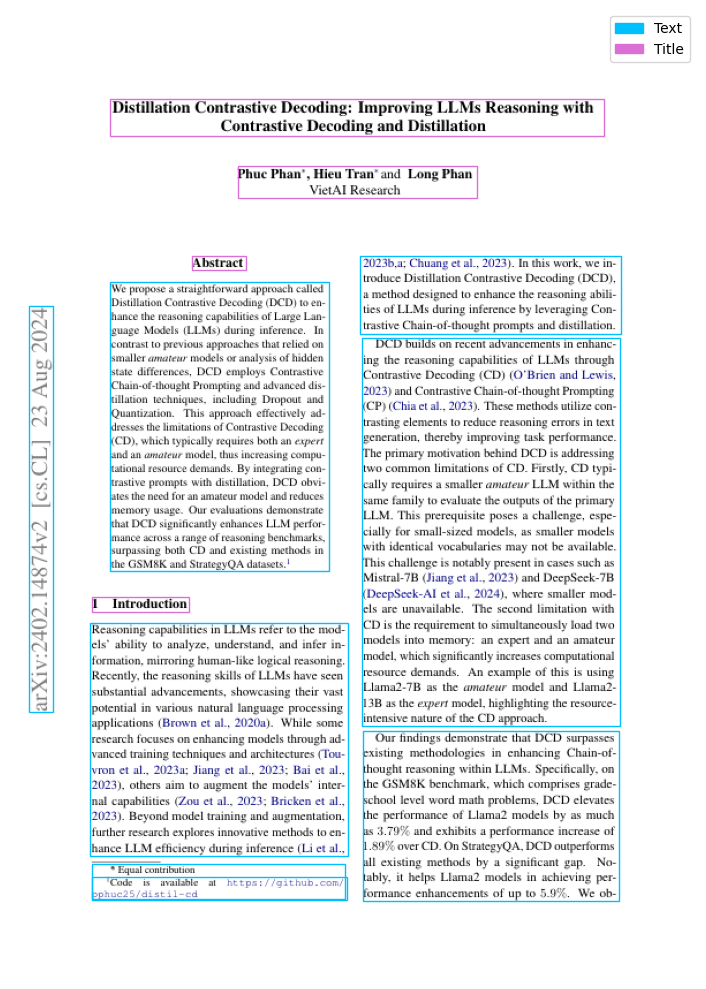

Distillation Contrastive Decoding: Improving LLMs Reasoning with Contrastive Decoding and Distillation

Phuc Phan∗, Hieu Tran∗ and Long Phan VietAI Research

4 2 0 2 g u A 3 2 ] L C . s c [ 2 v 4 7 8 4 1 . 2 0 4 2 : v i X r a

Abstract

We propose a straightforward approach called Distillation Contrastive Decoding (DCD) to en- hance the reasoning capabilities of Large Lan- guage Models (LLMs) during inference. In contrast to previous approaches that relied on smaller amateur models or analysis of hidden state differences, DCD employs Contrastive Chain-of-thought Prompting and advanced dis- tillation techniques, including Dropout and Quantization. This approach effectively ad- dresses the limitations of Contrastive Decoding (CD), which typically requires both an expert and an amateur model, thus increasing compu- tational resource demands. By integrating con- trastive prompts with distillation, DCD obvi- ates the need for an amateur model and reduces memory usage. Our evaluations demons

In [25]:
render_page(docs,1)

## Transform into Embeddings

In [43]:
from langchain_community.vectorstores.utils import filter_complex_metadata
# Filter out coordinates metadata which is not supported in vector store
filtered_docs = filter_complex_metadata(docs)
print(filtered_docs)

[Document(metadata={'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 1, 'filename': '0KCrVeiC5zEJ.pdf', 'category': 'Title', 'element_id': '02adfadb9fba5f3f602d1e32ddc55b0b'}, page_content='Distillation Contrastive Decoding: Improving LLMs Reasoning with Contrastive Decoding and Distillation'), Document(metadata={'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 1, 'filename': '0KCrVeiC5zEJ.pdf', 'category': 'Title', 'element_id': 'f635671ec7a802ea441d41af7194a8af'}, page_content='Phuc Phan∗, Hieu Tran∗ and Long Phan VietAI Research'), Document(metadata={'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 1, 'parent_id': 'f635671ec7a802ea441d41af7194a8af', 'filename': '0KCrVeiC5zEJ.pdf', 'category': 'NarrativeText', 'element_id': 'c1ca1e8812f489e94f6cf80276f8bff6'}, page_content='4 2 0 2 g u A 3 2 ] L C . s c [ 2 v 4 7 8 4 1 . 2 0 4 2 : v i X r a'), D

In [ ]:
from langchain.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings

chroma_store = Chroma.from_documents(
    documents=filtered_docs,
    embedding=OpenAIEmbeddings(),
    persist_directory="scholar_embeddings"
)

# No longer userful as docs are automatically persisted.
# https://python.langchain.com/api_reference/community/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma.persist
# chroma_store.persist()

INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


## Ask questions

In [53]:
chroma_store.search('Contrastive Decoding', search_type="similarity")

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'category': 'Title', 'element_id': '2c9b424fb9248df7b167d2acaba32937', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 3, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='Contrastive Decoding'),
 Document(metadata={'category': 'Title', 'element_id': 'cefc1454436096d2fd95a99ada1bdf53', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 3, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='3.1 Contrastive Decoding'),
 Document(metadata={'category': 'Title', 'element_id': '9bede6ca5474472cb0da29e4788774b6', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 3, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='Distillation Contrastive Decoding'),
 Document(metadata={'category': 'Title', 'element_id': '737bf4b64f07cf568fda99637bd6420d', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 4, 'source': 'data/scholar_corp

In [56]:
chroma_store.search('Does this paper mentions contrastive decoding?', search_type="similarity")

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(metadata={'category': 'Title', 'element_id': '2c9b424fb9248df7b167d2acaba32937', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 3, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='Contrastive Decoding'),
 Document(metadata={'category': 'Title', 'element_id': 'cefc1454436096d2fd95a99ada1bdf53', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 3, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='3.1 Contrastive Decoding'),
 Document(metadata={'category': 'NarrativeText', 'element_id': '71c7717b830fda9b8cf8d96b2ba694d2', 'filename': '0KCrVeiC5zEJ.pdf', 'filetype': 'application/pdf', 'page_number': 2, 'source': 'data/scholar_corpus/0KCrVeiC5zEJ.pdf'}, page_content='In summary, our main contributions are: (1) Introducing a straightforward approach that com- bines Contrastive Chain-of-thought Prompting, Contrastive Decoding, and Distillation to enhance LLM reasoning abilities, eliminating the

In [54]:
from langchain.chains import VectorDBQA
from langchain_community.chat_models import ChatOllama

model_local = ChatOllama(model="qwen:7b")
persist_directory = "scholar_embeddings"

# TODO: Need refactor, Deprecated class
# https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html#langchain_core.vectorstores.in_memory.InMemoryVectorStore
qa = VectorDBQA.from_chain_type(llm=model_local, chain_type="stuff", vectorstore=chroma_store)

c:\Users\Delusion\miniconda3\envs\paperRAG\Lib\site-packages\langchain\chains\retrieval_qa\base.py:316: UserWarning: `VectorDBQA` is deprecated - please use `from langchain.chains import RetrievalQA`
  warnings.warn(


In [55]:
query = "Does this paper mentions contrastive decoding?"
result = qa.run(query)

print(result)

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Yes, the paper you're referring to does mention contrastive decoding. The authors introduce a straightforward approach that combines Contrastive Chain-of-though Prompting, Contrastive Decoding, and Distillation to enhance large language model (LLM) reasoning abilities. They demonstrate significant performance improvements across various reasoning benchmarks compared to just using Contrastive Decoding or other methods.
